<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/trading%20bot%20deep%20q%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install pandas_ta
!pip install tf_agents[reverb]

In [51]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [52]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [64]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [53]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']
change = df['ACh']

In [67]:
RSI = ta.rsi(close,14,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,14)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,14,scalar=1)
CHANGE = get_relative_change(close,"Change")
INDICATORS = pd.concat([CHANGE,RSI,AROON_UP,AROON_DOWN,CCI,RVI],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

change = INDICATORS.pop('Change')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()

np.set_printoptions(suppress=True)
print(INDICATORS)

[[0.38187407 1.         0.71428571 0.39334634 0.85330187]
 [0.52438576 0.92857143 0.64285714 0.42260631 0.87272338]
 [0.45394255 0.85714286 0.57142857 0.38867102 0.75057577]
 ...
 [0.63073968 0.42857143 0.85714286 0.63507997 0.67330809]
 [0.60441535 0.35714286 0.78571429 0.61566583 0.57482093]
 [0.60055924 0.28571429 0.71428571 0.59201605 0.48856795]]


(5400.0, 5500.0)

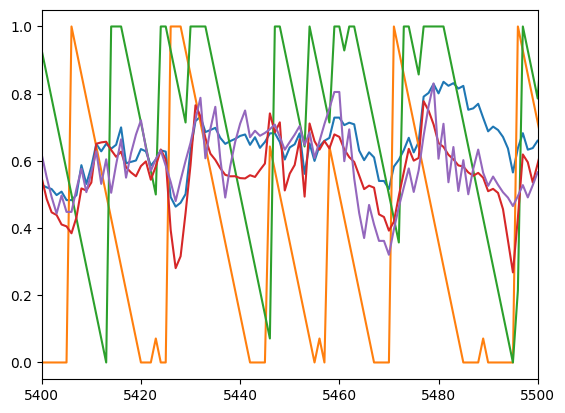

In [55]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [56]:
max_ep_len = 5000

In [72]:
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(7,), dtype=np.float32, minimum=-10,maximum=10, name='observation')

    self._trade_info = np.array([0,0])
    self._state = np.append(INDICATORS[0],(0,0))
    self._episode_ended = False
    self._count = 0
    self._net_profit = 0

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):


    self._trade_info = np.array([0,0])
    self._state = np.append(INDICATORS[0],(0,0))
    self._episode_ended = False
    self._count = 0
    self._net_profit = 0
    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    exit_trade = True if action == 0 else False
    hold_state = True if action == 1 else False
    buy_signal = True if action == 2 else False
    sell_signal = True if action == 3 else False

    cash_out_val = 0
    invalid_action = False

    in_trade = True if self._trade_info[1] != 0 else False

    if exit_trade and not in_trade:
      invalid_action = True



    #trade_info 0 = trade value
    #trade_info 1 = trade direction

    if buy_signal:
      cash_out_val = self._trade_info[0]
      self._trade_info[0] = change[self._count]*.9
      self._trade_info[1] = 1
    elif sell_signal:
      cash_out_val = self._trade_info[0]
      self._trade_info[0] = change[self._count]*-.9
      self._trade_info[1] = -1
    elif exit_trade:
      cash_out_val = self._trade_info[0]
      self._trade_info[0] = 0
      self._trade_info[1] = 0
    else:
      self._trade_info[0] += change[self._count]*self._trade_info[1]
      self._trade_info[1] = self._trade_info[1]

    self._net_profit += cash_out_val

    #update state
    self._state = np.append(INDICATORS[self._count],(self._trade_info[0],self._trade_info[1]))

    if self._count >= max_ep_len:
      self._episode_ended = True

    self._count += 1

    if self._episode_ended:
      reward = -10 if invalid_action else self._net_profit
      return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
    else:
      reward = cash_out_val
      return ts.transition(
          np.array(self._state, dtype=np.float32), reward=reward, discount=.5)

In [76]:
env = TradingEnv()

utils.validate_py_environment(env, episodes=2)

In [87]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [78]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [79]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [80]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [81]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [82]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [83]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [84]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [88]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0.5, dtype=float32),
  'observation': array([0.20280905, 0.85714287, 0.5       , 0.40135133, 0.25485438,
        0.        , 1.        ], dtype=float32),
  'reward': array(0., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [89]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 7), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [90]:
iterator = iter(dataset)
print(iterator)

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)